In [255]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/global/homes/l/lbigwood/S4Mock/')
from corr_func_tools import calc_wtheta, create_axes
import S4Mock_io
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table,vstack,join
import glob
import astropy.io.fits as fits
from desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, mws_mask 
nbins=30
import Corrfunc
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.utils import convert_3d_counts_to_cf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
fassign = Table(S4Mock_io.read_fassign_mock())

In [248]:
favail = Table(S4Mock_io.read_favail_mock())

In [142]:
mask,idx = np.unique(fassign['TARGETID'].data,return_index=True)
fassign = fassign[idx]


In [249]:
mask,idx,counts = np.unique(favail['TARGETID'].data,return_index=True,return_counts=True)
favail = favail[idx]


In [250]:
favail['COUNT']= counts
favail['WEIGHT']=1/counts
#updates = np.full(len(favail[(favail['WEIGHT']>1/8)]['WEIGHT']),1/8)
#favail['WEIGHT'][(favail['WEIGHT']>1/8)]=updates


(array([  1910.,   9608., 173288., 311646., 533485.,      0., 666772.,
        616975.,      0., 457056.,      0.,      0., 303228.,      0.,
             0., 219897.,      0.,      0.,      0., 837335.]),
 array([0.05555556, 0.06277778, 0.07      , 0.07722222, 0.08444444,
        0.09166667, 0.09888889, 0.10611111, 0.11333333, 0.12055556,
        0.12777778, 0.135     , 0.14222222, 0.14944444, 0.15666667,
        0.16388889, 0.17111111, 0.17833333, 0.18555556, 0.19277778,
        0.2       ]),
 <a list of 20 Patch objects>)

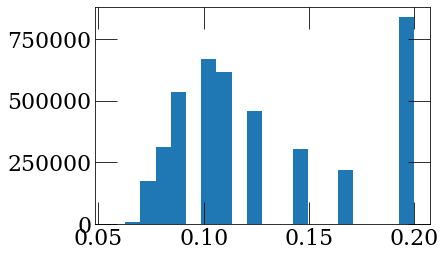

In [185]:
plt.hist(favail['WEIGHT'],bins=20)

In [127]:
init_ledger = S4Mock_io.read_init_ledger()

In [128]:
init_ledger = init_ledger[((init_ledger['SV3_BGS_TARGET'] & bgs_mask['BGS_BRIGHT']) != 0)]

In [251]:
assigned_ledger = init_ledger[np.in1d(init_ledger['TARGETID'],fassign['TARGETID'])]
avail_ledger = init_ledger[np.in1d(init_ledger['TARGETID'],favail['TARGETID'])]

In [252]:
assigned_ledger=Table(assigned_ledger)

In [253]:
weight_assigned_ledger = join(assigned_ledger, favail,keys='TARGETID', join_type='left')

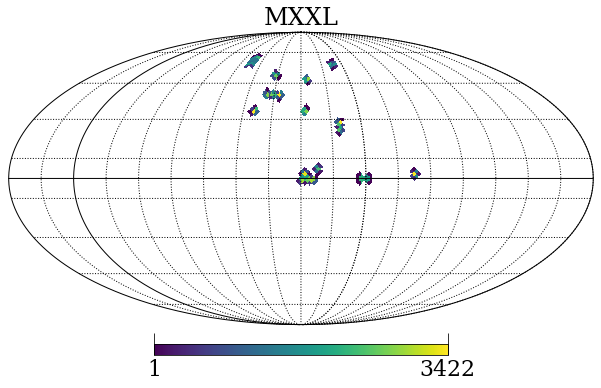

In [132]:
import geometry
import healpy as hp
target_pixel_density = geometry.targ_hpmap(weight_assigned_ledger)
hp.mollview(target_pixel_density,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title='MXXL')
hp.graticule(dpar=5, dmer=5)

In [240]:
sv3_rand = S4Mock_io.read_sv3_randoms(number=1)

In [241]:
mask,idx,counts = np.unique(sv3_rand['TARGETID'].data,return_index=True,return_counts=True)
sv3_rand = sv3_rand[idx]

sv3_rand['COUNT']= counts
sv3_rand['WEIGHT']=1/counts

In [227]:
updates = np.full(len(sv3_rand[(sv3_rand['WEIGHT']>1/8)]['WEIGHT']),1/8)
sv3_rand['WEIGHT'][(sv3_rand['WEIGHT']>1/8)]=updates

(array([2.80000e+01, 1.47700e+03, 5.65700e+03, 1.69210e+04, 3.82330e+04,
        6.22580e+04, 7.38410e+04, 0.00000e+00, 6.55660e+04, 1.94147e+05]),
 array([0.05555556, 0.0625    , 0.06944444, 0.07638889, 0.08333333,
        0.09027778, 0.09722222, 0.10416667, 0.11111111, 0.11805556,
        0.125     ]),
 <a list of 10 Patch objects>)

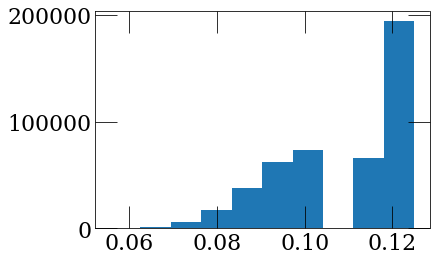

In [228]:
plt.hist(sv3_rand['WEIGHT'])

In [ ]:
x = fits.open('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/everest/LSScats/2.1/BGS_BRIGHT_0_full_noveto.ran.fits')
ran = x[1].data 



In [24]:
"""
sv3_rand['COUNT']= counts
sv3_rand['WEIGHT']=1/counts
#updates = np.full(len(sv3_rand[(sv3_rand['WEIGHT']>0.3)]['WEIGHT']),0.3)
#sv3_rand['WEIGHT'][(sv3_rand['WEIGHT']>0.3)]=updates

sv3_rand = sv3_rand[(sv3_rand['WEIGHT']<0.3)]
"""

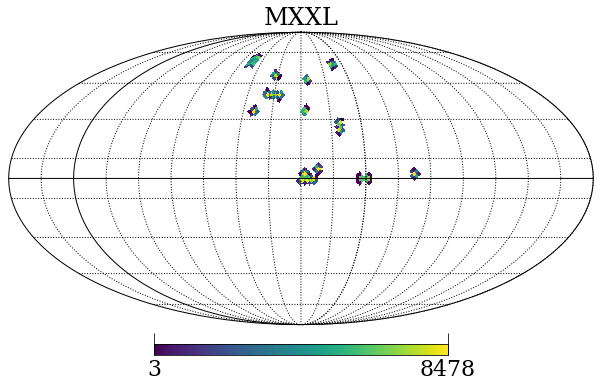

In [199]:
import geometry
import healpy as hp
target_pixel_density = geometry.targ_hpmap(sv3_rand)
hp.mollview(target_pixel_density,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title='MXXL')
hp.graticule(dpar=5, dmer=5)

In [232]:
#wtheta_mock_fba = calc_wtheta(weight_assigned_ledger['RA'],weight_assigned_ledger['DEC'],ran['RA'],ran['DEC'])

RA = weight_assigned_ledger['RA'].data
DEC = weight_assigned_ledger['DEC'].data
N = len(RA)


rand_RA = sv3_rand['RA']
rand_DEC = sv3_rand['DEC']
rand_N = len(rand_RA)

# Setup the bins
bins = np.logspace(-3, 1, nbins + 1, base=10)
#bins = np.linspace(0.001, 10.0, nbins + 1)

# Number of threads to use
nthreads = 2

# Auto pair counts in DD
autocorr=1
DD_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC)


# Cross pair counts in DR
autocorr=0
DR_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC,RA2=rand_RA, DEC2=rand_DEC)


# Auto pairs counts in RR
autocorr=1
RR_counts = DDtheta_mocks(autocorr, nthreads, bins, rand_RA, rand_DEC)

DD_c = []
for i in range(len(DD_counts)):
    DD_c.append(DD_counts[i][3])
DD_c = np.array(DD_c)

DR_c = []
for i in range(len(DR_counts)):
    DR_c.append(DR_counts[i][3])
DR_c = np.array(DR_c)

RR_c = []
for i in range(len(RR_counts)):
    RR_c.append(RR_counts[i][3])
RR_c = np.array(RR_c)

wtheta_mock_fba = []
for i in range(len(RR_c)):
    wtheta_mock_fba.append(-1+(DD_c[i]*RR_c[i])/(DR_c[i])**2)
wtheta_mock_fba = np.array(wtheta_mock_fba)


In [254]:
import Corrfunc
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.utils import convert_3d_counts_to_cf

RA = weight_assigned_ledger['RA'].data
DEC = weight_assigned_ledger['DEC'].data
N = len(RA)


rand_RA = sv3_rand['RA']
rand_DEC = sv3_rand['DEC']
rand_N = len(rand_RA)

# Setup the bins
bins = np.logspace(-3, 1, nbins + 1, base=10)
#bins = np.linspace(0.001, 10.0, nbins + 1)

# Number of threads to use
nthreads = 2

# Auto pair counts in DD
autocorr=1
DD_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC,weights1=weight_assigned_ledger['WEIGHT'].data,weight_type='pair_product')


# Cross pair counts in DR
autocorr=0
DR_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC,RA2=rand_RA, DEC2=rand_DEC,weights1=weight_assigned_ledger['WEIGHT'].data,weights2=sv3_rand['WEIGHT'],weight_type='pair_product')


# Auto pairs counts in RR
autocorr=1
RR_counts = DDtheta_mocks(autocorr, nthreads, bins, rand_RA, rand_DEC,weights1=sv3_rand['WEIGHT'],weight_type='pair_product')


# All the pair counts are done, get the angular correlation function
#wtheta_mock_fba_corr = convert_3d_counts_to_cf(N, N, rand_N, rand_N, DD_counts, DR_counts,DR_counts, RR_counts)

DD_c = []
for i in range(len(DD_counts)):
    DD_c.append(DD_counts[i][3]*(DD_counts[i][4]))
DD_c = np.array(DD_c)

DR_c = []
for i in range(len(DR_counts)):
    DR_c.append(DR_counts[i][3]*(DR_counts[i][4]))
DR_c = np.array(DR_c)

RR_c = []
for i in range(len(RR_counts)):
    RR_c.append(RR_counts[i][3]*(RR_counts[i][4]))
RR_c = np.array(RR_c)

wtheta_mock_fba_corr = []
for i in range(len(RR_c)):
    wtheta_mock_fba_corr.append(-1+(DD_c[i]*RR_c[i])/(DR_c[i])**2)
wtheta_mock_fba_corr = np.array(wtheta_mock_fba_corr)


In [24]:
#wtheta_mock_init = calc_wtheta(init_ledger['RA'],init_ledger['DEC'],sv3_rand['RA'],sv3_rand['DEC'])

In [203]:
nbins=30

x = fits.open('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/everest/LSScats/2.1/BGS_BRIGHT_clustering.dat.fits')
dat = x[1].data


x = fits.open('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/everest/LSScats/2.1/BGS_BRIGHT_0_clustering.ran.fits')
ran = x[1].data 

#fba_wtheta = calc_wtheta(dat['RA'],dat['DEC'],ran['RA'],ran['DEC'],nbins=nbins)

#wtheta_mock_fba = calc_wtheta(assigned_ledger['RA'],assigned_ledger['DEC'],sv3_rand['RA'],sv3_rand['DEC'])

RA = dat['RA'].data
DEC = dat['DEC'].data
N = len(RA)


rand_RA = ran['RA']
rand_DEC = ran['DEC']
rand_N = len(rand_RA)

# Setup the bins
bins = np.logspace(-3, 1, nbins + 1, base=10)
#bins = np.linspace(0.001, 10.0, nbins + 1)

# Number of threads to use
nthreads = 2

# Auto pair counts in DD
autocorr=1
DD_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC)


# Cross pair counts in DR
autocorr=0
DR_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC,RA2=rand_RA, DEC2=rand_DEC)


# Auto pairs counts in RR
autocorr=1
RR_counts = DDtheta_mocks(autocorr, nthreads, bins, rand_RA, rand_DEC)

DD_c = []
for i in range(len(DD_counts)):
    DD_c.append(DD_counts[i][3])
DD_c = np.array(DD_c)

DR_c = []
for i in range(len(DR_counts)):
    DR_c.append(DR_counts[i][3])
DR_c = np.array(DR_c)

RR_c = []
for i in range(len(RR_counts)):
    RR_c.append(RR_counts[i][3])
RR_c = np.array(RR_c)

fba_wtheta = []
for i in range(len(RR_c)):
    fba_wtheta.append(-1+(DD_c[i]*RR_c[i])/(DR_c[i])**2)
fba_wtheta = np.array(fba_wtheta)

In [206]:
#Table(dat)

import Corrfunc
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.utils import convert_3d_counts_to_cf

RA = dat['RA'].data
DEC = dat['DEC'].data
N = len(RA)


rand_RA = ran['RA']
rand_DEC = ran['DEC']
rand_N = len(rand_RA)

# Setup the bins
bins = np.logspace(-3, 1, nbins + 1, base=10)
#bins = np.linspace(0.001, 10.0, nbins + 1)

# Number of threads to use
nthreads = 2

# Auto pair counts in DD
autocorr=1
DD_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC,weights1=dat['WEIGHT'],weight_type='pair_product')


# Cross pair counts in DR
autocorr=0
DR_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC,RA2=rand_RA, DEC2=rand_DEC,weights1=dat['WEIGHT'],weight_type='pair_product')


# Auto pairs counts in RR
autocorr=1
RR_counts = DDtheta_mocks(autocorr, nthreads, bins, rand_RA, rand_DEC)

DD_c = []
for i in range(len(DD_counts)):
    DD_c.append(DD_counts[i][3]*(DD_counts[i][4]))
DD_c = np.array(DD_c)

DR_c = []
for i in range(len(DR_counts)):
    DR_c.append(DR_counts[i][3]*(DR_counts[i][4]))
DR_c = np.array(DR_c)

RR_c = []
for i in range(len(RR_counts)):
    RR_c.append(RR_counts[i][3])
RR_c = np.array(RR_c)

fba_wtheta_corr = []
for i in range(len(RR_c)):
    fba_wtheta_corr.append(-1+(DD_c[i]*RR_c[i])/(DR_c[i])**2)
fba_wtheta_corr = np.array(fba_wtheta_corr)

In [111]:


#np.save('fba_wtheta_corr',fba_wtheta_corr)

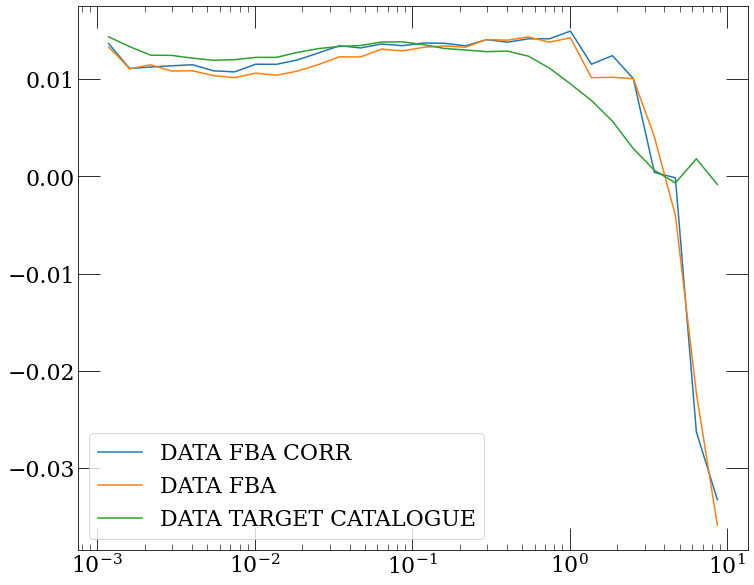

In [207]:
plt.figure(figsize=(12,10))
plt.rc('xtick',direction='in',labelsize=22,top=True)
plt.rc('ytick',direction='in',labelsize=22, right = True)
plt.rc('xtick.major',size = 22)
plt.rc('xtick.minor',size = 6)
plt.rc('ytick.major',size = 22)
plt.rc('ytick.minor',size = 6)
plt.rc('axes', labelsize = 22)
plt.rc('legend',fontsize=22)
plt.rc('font', family='serif',size=20)

#mxxl all
x_axis1,y_axis1 = create_axes(fba_wtheta_corr)
plt.plot(x_axis1,y_axis1,label='DATA FBA CORR')

x_axis1,y_axis1 = create_axes(fba_wtheta)
plt.plot(x_axis1,y_axis1,label='DATA FBA')

targ_wtheta = np.load('/global/u2/l/lbigwood/S4Mock/docs/nb/targ_wtheta.npy')

x_axis1,y_axis1 = create_axes(targ_wtheta)
plt.plot(x_axis1,y_axis1,label='DATA TARGET CATALOGUE')


plt.xscale('log')
plt.legend()

In [105]:
np.save('wtheta_mock_fba_corr',wtheta_mock_fba_corr)

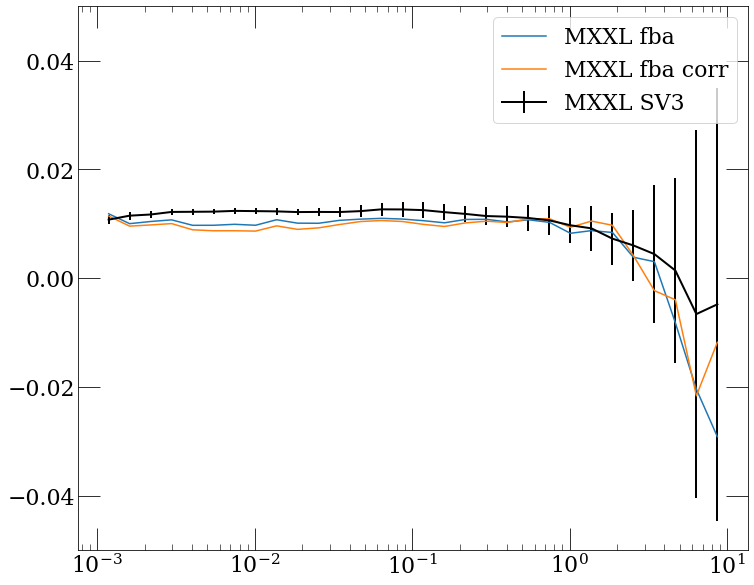

In [239]:
plt.figure(figsize=(12,10))
plt.rc('xtick',direction='in',labelsize=22,top=True)
plt.rc('ytick',direction='in',labelsize=22, right = True)
plt.rc('xtick.major',size = 22)
plt.rc('xtick.minor',size = 6)
plt.rc('ytick.major',size = 22)
plt.rc('ytick.minor',size = 6)
plt.rc('axes', labelsize = 22)
plt.rc('legend',fontsize=22)
plt.rc('font', family='serif',size=20)
"""
#mxxl all
x_axis1,y_axis1 = create_axes(wtheta_mock_init)
plt.plot(x_axis1,y_axis1,label='MXXL init')
"""
#x_axis1,y_axis1 = create_axes(fba_wtheta)
#plt.plot(x_axis1,y_axis1,label='Data fba')

x_axis1,y_axis1 = create_axes(wtheta_mock_fba)
plt.plot(x_axis1,y_axis1,label='MXXL fba')

x_axis1,y_axis1 = create_axes(wtheta_mock_fba_corr)
plt.plot(x_axis1,y_axis1,label='MXXL fba corr')

wtheta_all = np.load('/global/u2/l/lbigwood/S4Mock/wtheta_all.npy')
mean = np.mean(wtheta_all,axis=0)
stdev = np.std(wtheta_all,axis=0)

x_axis1,y_axis1 = create_axes(mean)
x_axis1,y_axis_err = create_axes(stdev)

plt.errorbar(x_axis1,y_axis1,yerr=y_axis_err,color= 'black',label='MXXL SV3',zorder=2,linewidth=2)
plt.ylim(-0.05,0.05)
plt.xscale('log')
plt.legend()

In [59]:
w

[2.609719192453925,
 1.7273649775826363,
 1.4045634554221813,
 1.1306663268791155,
 0.801601247837844,
 0.6275321745042728,
 0.49991780806224684,
 0.38410452070199463,
 0.33177506375894406,
 0.244330710622918,
 0.1907480135263604,
 0.15718881428688247,
 0.12549667761462202,
 0.0994719120415759,
 0.07688155842748134,
 0.05849068716661421,
 0.044066524139587004,
 0.03656182176957712,
 0.02866854198294755,
 0.021404082545850134,
 0.017398580767577165,
 0.013011768696304049,
 0.00818509573534798,
 0.006780798203417371,
 0.005100558582581183,
 0.0018279465607775602,
 0.0011293183354992298,
 -0.00238133852612743,
 -0.004632101598146088,
 -0.005176584908051285]

In [60]:
wtheta_mock_fba

array([ 2.60971919e+00,  1.72736498e+00,  1.40456346e+00,  1.13066633e+00,
        8.01601248e-01,  6.27532175e-01,  4.99917808e-01,  3.84104521e-01,
        3.31775064e-01,  2.44330711e-01,  1.90748014e-01,  1.57188814e-01,
        1.25496678e-01,  9.94719120e-02,  7.68815584e-02,  5.84906872e-02,
        4.40665241e-02,  3.65618218e-02,  2.86685420e-02,  2.14040825e-02,
        1.73985808e-02,  1.30117687e-02,  8.18509574e-03,  6.78079820e-03,
        5.10055858e-03,  1.82794656e-03,  1.12931834e-03, -2.38133853e-03,
       -4.63210160e-03, -5.17658491e-03])

In [25]:
wtheta_mock_fba_corr

array([ 2.24705252e+00,  1.69292111e+00,  1.37001326e+00,  1.12941712e+00,
        8.24140458e-01,  6.45956037e-01,  5.07303001e-01,  3.94981659e-01,
        3.32649466e-01,  2.47934790e-01,  1.93560462e-01,  1.59266730e-01,
        1.27800057e-01,  1.01781248e-01,  7.88839956e-02,  6.03308388e-02,
        4.56996344e-02,  3.80047628e-02,  2.98978634e-02,  2.24386290e-02,
        1.82568357e-02,  1.36211263e-02,  8.54884137e-03,  6.97825293e-03,
        5.15932273e-03,  1.86792905e-03,  1.12929730e-03, -2.37315844e-03,
       -4.33414853e-03, -4.95361693e-03])

In [ ]:
nbins=30

x = fits.open('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/everest/LSScats/2.1/BGS_BRIGHT_clustering.dat.fits')
dat = x[1].data


x = fits.open('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/everest/LSScats/2.1/BGS_BRIGHT_0_clustering.ran.fits')
ran = x[1].data 

#fba_wtheta = calc_wtheta(dat['RA'],dat['DEC'],ran['RA'],ran['DEC'],nbins=nbins)

#wtheta_mock_fba = calc_wtheta(assigned_ledger['RA'],assigned_ledger['DEC'],sv3_rand['RA'],sv3_rand['DEC'])

RA = dat['RA'].data
DEC = dat['DEC'].data
N = len(RA)


rand_RA = ran['RA']
rand_DEC = ran['DEC']
rand_N = len(rand_RA)

# Setup the bins
bins = np.logspace(-3, 1, nbins + 1, base=10)
#bins = np.linspace(0.001, 10.0, nbins + 1)

# Number of threads to use
nthreads = 2

# Auto pair counts in DD
autocorr=1
DD_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC)


# Cross pair counts in DR
autocorr=0
DR_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC,RA2=rand_RA, DEC2=rand_DEC)


# Auto pairs counts in RR
autocorr=1
RR_counts = DDtheta_mocks(autocorr, nthreads, bins, rand_RA, rand_DEC)

DD_c = []
for i in range(len(DD_counts)):
    DD_c.append(DD_counts[i][3])
DD_c = np.array(DD_c)

DR_c = []
for i in range(len(DR_counts)):
    DR_c.append(DR_counts[i][3])
DR_c = np.array(DR_c)

RR_c = []
for i in range(len(RR_counts)):
    RR_c.append(RR_counts[i][3])
RR_c = np.array(RR_c)

fba_wtheta = []
for i in range(len(RR_c)):
    fba_wtheta.append(-1+(DD_c[i]*RR_c[i])/(DR_c[i])**2)
fba_wtheta = np.array(fba_wtheta)